## Imports

In [1]:
#imports
import pandas as pd
import numpy as np

#maps
import folium
from folium import plugins
from matplotlib.colors import rgb2hex

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# ml preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# ml models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# ml evaluation
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

## Load data

In [2]:
# load the data
data_path = 'Datasets/2021-2023/CSB_2021-2023_All.csv'
initial_data = pd.read_csv(data_path)

/var/folders/n3/spvzfspj1gn51bldz75lhrt40000gn/T/ipykernel_3967/3892218257.py:3: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  initial_data = pd.read_csv(data_path)


In [3]:
# copy data (it's faster to copy than to load it again)
bike_data = initial_data.copy()

In [4]:
## Check for missing and Null data

In [5]:
# check for null values
bike_data.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    468710
start_station_id      468710
end_station_name      521058
end_station_id        521058
start_lat                  2
start_lng                  2
end_lat                13695
end_lng                13695
member_casual              0
dtype: int64

In [6]:
# check for missing values
bike_data.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    468710
start_station_id      468710
end_station_name      521058
end_station_id        521058
start_lat                  2
start_lng                  2
end_lat                13695
end_lng                13695
member_casual              0
dtype: int64

## Inspect the data

In [7]:
# check data types
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8180626 entries, 0 to 8180625
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 811.4+ MB


In [8]:
bike_data.describe()

,start_lat,start_lng,end_lat,end_lng
count,8.180624e+06,8.180624e+06,8.166931e+06,8.166931e+06
mean,3.890293e+01,-7.703172e+01,3.890184e+01,-7.703127e+01
std,2.656915e-02,3.286265e-02,5.567502e-02,1.025279e-01
min,3.877000e+01,-7.740000e+01,0.000000e+00,-7.756000e+01
25%,3.889050e+01,-7.704468e+01,3.889046e+01,-7.704468e+01
50%,3.890267e+01,-7.703174e+01,3.890206e+01,-7.703169e+01
75%,3.891369e+01,-7.701377e+01,3.891261e+01,-7.701350e+01
max,3.913000e+01,-7.682000e+01,3.918000e+01,0.000000e+00


In [9]:
# Because a lot of columns are of type object, we don't get much out of the data.
# Let's convert the column dtypes.

## Convert dtypes

In [10]:
# convert the object type columns to more useful data types

# convert categorical data
bike_data['rideable_type'] = pd.Categorical(bike_data['rideable_type'])
bike_data['member_casual'] = pd.Categorical(bike_data['member_casual'])

# convert datetime data
bike_data['started_at'] = pd.to_datetime(bike_data['started_at'])
bike_data['ended_at'] = pd.to_datetime(bike_data['ended_at'])

# droping the two rows with 'MTL-ECO5-03' as this is probably an error
bike_data = bike_data.drop(bike_data[bike_data['end_station_id'] == 'MTL-ECO5-03'].index)

# convert station id's to float
bike_data['end_station_id'] = pd.to_numeric(bike_data['end_station_id'], errors='coerce')
bike_data['start_station_id'] = pd.to_numeric(bike_data['start_station_id'], errors='coerce')

## Inspect the data again

In [11]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8180624 entries, 0 to 8180625
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    float64       
 6   end_station_name    object        
 7   end_station_id      float64       
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
dtypes: category(2), datetime64[ns](2), float64(6), object(3)
memory usage: 764.6+ MB


In [12]:
bike_data.describe()

,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng
count,8180624,8180624,7.711914e+06,7.659566e+06,8.180624e+06,8.180624e+06,8.166931e+06,8.166931e+06
mean,2022-05-21 15:41:19.305605376,2022-05-21 16:05:15.981119744,3.136749e+04,3.136883e+04,3.890293e+01,-7.703172e+01,3.890184e+01,-7.703127e+01
min,2021-01-01 00:08:33,2021-01-01 00:21:00,3.020000e+04,3.020000e+04,3.877000e+01,-7.740000e+01,0.000000e+00,-7.756000e+01
25%,2021-10-05 22:01:12,2021-10-05 22:24:05.750000128,3.121200e+04,3.121400e+04,3.889050e+01,-7.704468e+01,3.889046e+01,-7.704468e+01
50%,2022-06-15 10:14:12.500000,2022-06-15 10:39:25,3.127700e+04,3.127500e+04,3.890267e+01,-7.703174e+01,3.890206e+01,-7.703169e+01
75%,2022-12-11 21:21:40.750000128,2022-12-11 21:35:58.500000,3.160500e+04,3.160800e+04,3.891369e+01,-7.701377e+01,3.891261e+01,-7.701350e+01
max,2023-06-30 23:59:35,2023-07-11 02:02:21,3.320000e+04,3.320000e+04,3.913000e+01,-7.682000e+01,3.918000e+01,0.000000e+00
std,NaN,NaN,2.585772e+02,2.581412e+02,2.656915e-02,3.286265e-02,5.567502e-02,1.025279e-01


In [13]:
# check for missing values
bike_data.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    468710
start_station_id      468710
end_station_name      521058
end_station_id        521058
start_lat                  0
start_lng                  0
end_lat                13693
end_lng                13693
member_casual              0
dtype: int64

In [14]:
# Now we see more in the data, but still not a lot based on the describe function.
# Interesting is that the last ride ended 11 days after the last ride started.
# We fortunately got rid of the missing data in start_lat/lng by deleting 'MTL-ECO5-03'.

In [15]:
bike_data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5CB9DFCECF79AF84,classic_bike,2021-01-01 00:08:33,2021-01-01 00:33:53,Maine Ave & 9th St SW,31646.0,Rosslyn Metro / Wilson Blvd & Ft Myer Dr,31015.0,38.880440,-77.025236,38.894600,-77.072305,member
1,629E059504606547,electric_bike,2021-01-01 00:13:43,2021-01-01 00:29:34,10th & U St NW,31111.0,NaN,NaN,38.917193,-77.025894,38.960000,-77.020000,casual
2,E74069873161EE33,electric_bike,2021-01-01 00:14:32,2021-01-01 00:28:45,17th & Corcoran St NW,31214.0,14th & Belmont St NW,31119.0,38.912138,-77.038568,38.920870,-77.031691,member
3,91F95E512CABC46A,classic_bike,2021-01-01 00:15:45,2021-01-01 00:21:20,Wilson Blvd. & N. Vermont St.,31926.0,Wilson Blvd. & N. Vermont St.,31926.0,38.879477,-77.114563,38.879477,-77.114563,member
4,DA46A05139C0EA2F,classic_bike,2021-01-01 00:17:46,2021-01-01 00:21:00,11th & Park Rd NW,31651.0,14th & Newton St NW,31649.0,38.931322,-77.028247,38.931991,-77.032956,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180621,E802A8D89245438B,electric_bike,2023-06-30 23:57:43,2023-07-01 00:07:16,NaN,NaN,14th & Newton St NW,31649.0,38.910000,-77.030000,38.931991,-77.032956,member
8180622,0448FEEB78F2B08D,classic_bike,2023-06-30 23:58:14,2023-07-01 00:24:14,18th & New Hampshire Ave NW,31324.0,Massachusetts Ave & Dupont Circle NW,31200.0,38.911268,-77.041829,38.910100,-77.044400,casual
8180623,5BE258BC59548BE9,classic_bike,2023-06-30 23:58:26,2023-07-01 00:20:06,18th & New Hampshire Ave NW,31324.0,Massachusetts Ave & Dupont Circle NW,31200.0,38.911268,-77.041829,38.910100,-77.044400,casual
8180624,5EAFC4B8F3E7680E,electric_bike,2023-06-30 23:59:01,2023-07-01 00:06:37,Adams Mill & Columbia Rd NW,31104.0,NaN,NaN,38.923005,-77.042420,38.930000,-77.030000,member


In [16]:
# get unique station names and ids
start_stations = bike_data[['start_station_name', 'start_station_id']].drop_duplicates(ignore_index=True)

# ignore NaN values
start_stations = start_stations[start_stations['start_station_name'].notna()]

#start_stations

In [17]:
# get unique station names and ids
end_stations = bike_data[['end_station_name', 'end_station_id']].drop_duplicates(ignore_index=True)

# ignore NaN values
end_stations = end_stations[end_stations['end_station_name'].notna()]

#end_stations

In [18]:
start_stations.rename(columns={
    'start_station_name' : 'station_name',
    'start_station_id' : 'station_id'
}, inplace=True)

#start_stations

In [19]:
end_stations.rename(columns={
    'end_station_name' : 'station_name',
    'end_station_id' : 'station_id'
}, inplace=True)

#end_stations

In [20]:
stations = pd.concat([start_stations, end_stations], ignore_index=True)
#stations

In [21]:
stations.drop_duplicates(subset='station_id', ignore_index=True, inplace=True)
stations

,station_name,station_id
0,Maine Ave & 9th St SW,31646.0
1,10th & U St NW,31111.0
2,17th & Corcoran St NW,31214.0
3,Wilson Blvd. & N. Vermont St.,31926.0
4,11th & Park Rd NW,31651.0
...,...,...
743,Arlington Blvd & Allen St,32268.0
744,Westbranch Dr & Jones Branch Dr,32270.0
745,Motivate Tech Office,32902.0
746,V1 Warehouse Test Station,32906.0


In [22]:
# calculate the number of rides starting from each station
station_counts = bike_data.groupby('start_station_id')['ride_id'].count().reset_index()
station_counts.rename(columns={'ride_id': 'start_station_count'}, inplace=True)

# merge the result with the 'stations' DataFrame
stations = pd.merge(stations, station_counts, left_on='station_id', right_on='start_station_id', how='left')
stations.drop(columns=['start_station_id'], inplace=True)

# replace NaN with 0 and convert to integers
stations['start_station_count'] = stations['start_station_count'].fillna(0).astype(int)


In [23]:
# calculate the number of rides ending at each station
station_counts = bike_data.groupby('end_station_id')['ride_id'].count().reset_index()
station_counts.rename(columns={'ride_id': 'end_station_count'}, inplace=True)

# merge the result with the 'stations' DataFrame
stations = pd.merge(stations, station_counts, left_on='station_id', right_on='end_station_id', how='left')
stations.drop(columns=['end_station_id'], inplace=True)

# replace NaN with 0 and convert to integers
stations['end_station_count'] = stations['end_station_count'].fillna(0).astype(int)

In [24]:
stations

,station_name,station_id,start_station_count,end_station_count
0,Maine Ave & 9th St SW,31646.0,40694,43141
1,10th & U St NW,31111.0,19801,19750
2,17th & Corcoran St NW,31214.0,51715,51910
3,Wilson Blvd. & N. Vermont St.,31926.0,3607,3430
4,11th & Park Rd NW,31651.0,24372,18892
...,...,...,...,...
743,Arlington Blvd & Allen St,32268.0,2,2
744,Westbranch Dr & Jones Branch Dr,32270.0,1,1
745,Motivate Tech Office,32902.0,0,12
746,V1 Warehouse Test Station,32906.0,0,8


In [25]:
# Are any of those stations maybe brand new and thus have only so little traffic?

In [26]:
# calculate the minimum started_at for each start station
started_at = bike_data.groupby('start_station_id')['started_at'].agg('min').reset_index()
started_at.rename(columns={'started_at': 'min_started_at'}, inplace=True)

# merge the result with the 'stations' DataFrame
stations = pd.merge(stations, started_at, left_on='station_id', right_on='start_station_id', how='left')
stations.drop(columns=['start_station_id'], inplace=True)

In [27]:
# calculate the maximum started_at for each start station
started_at = bike_data.groupby('start_station_id')['started_at'].agg('max').reset_index()
started_at.rename(columns={'started_at': 'max_started_at'}, inplace=True)

# merge the result with the 'stations' DataFrame
stations = pd.merge(stations, started_at, left_on='station_id', right_on='start_station_id', how='left')
stations.drop(columns=['start_station_id'], inplace=True)

In [28]:
# calculate how long the station has been online
stations['operation_time'] = stations['max_started_at'] - stations['min_started_at']

In [29]:
stations

,station_name,station_id,start_station_count,end_station_count,min_started_at,max_started_at,operation_time
0,Maine Ave & 9th St SW,31646.0,40694,43141,2021-01-01 00:08:33,2023-06-30 23:39:26,910 days 23:30:53
1,10th & U St NW,31111.0,19801,19750,2021-01-01 00:13:43,2023-06-30 23:17:45,910 days 23:04:02
2,17th & Corcoran St NW,31214.0,51715,51910,2021-01-01 00:14:32,2023-06-30 23:39:19,910 days 23:24:47
3,Wilson Blvd. & N. Vermont St.,31926.0,3607,3430,2021-01-01 00:15:45,2023-06-30 16:42:18,910 days 16:26:33
4,11th & Park Rd NW,31651.0,24372,18892,2021-01-01 00:17:46,2023-06-30 23:24:22,910 days 23:06:36
...,...,...,...,...,...,...,...
743,Arlington Blvd & Allen St,32268.0,2,2,2023-06-28 12:54:01,2023-06-29 17:09:48,1 days 04:15:47
744,Westbranch Dr & Jones Branch Dr,32270.0,1,1,2023-06-30 14:58:40,2023-06-30 14:58:40,0 days 00:00:00
745,Motivate Tech Office,32902.0,0,12,NaT,NaT,NaT
746,V1 Warehouse Test Station,32906.0,0,8,NaT,NaT,NaT


In [30]:
# Get location data to be able to put the stations on a map later

In [31]:
# get the lat for each station
end_station_lat = bike_data.groupby('end_station_id')['end_lat'].first().reset_index()

# merge the result with the 'stations' DataFrame
stations = pd.merge(stations, end_station_lat, left_on='station_id', right_on='end_station_id', how='left')
stations.drop(columns=['end_station_id'], inplace=True)

In [32]:
# get the lng for each station
end_station_lng = bike_data.groupby('end_station_id')['end_lng'].first().reset_index()

# merge the result with the 'stations' DataFrame
stations = pd.merge(stations, end_station_lng, left_on='station_id', right_on='end_station_id', how='left')
stations.drop(columns=['end_station_id'], inplace=True)

In [33]:
stations

,station_name,station_id,start_station_count,end_station_count,min_started_at,max_started_at,operation_time,end_lat,end_lng
0,Maine Ave & 9th St SW,31646.0,40694,43141,2021-01-01 00:08:33,2023-06-30 23:39:26,910 days 23:30:53,38.880714,-77.025327
1,10th & U St NW,31111.0,19801,19750,2021-01-01 00:13:43,2023-06-30 23:17:45,910 days 23:04:02,38.917200,-77.025900
2,17th & Corcoran St NW,31214.0,51715,51910,2021-01-01 00:14:32,2023-06-30 23:39:19,910 days 23:24:47,38.912100,-77.038700
3,Wilson Blvd. & N. Vermont St.,31926.0,3607,3430,2021-01-01 00:15:45,2023-06-30 16:42:18,910 days 16:26:33,38.879477,-77.114563
4,11th & Park Rd NW,31651.0,24372,18892,2021-01-01 00:17:46,2023-06-30 23:24:22,910 days 23:06:36,38.931322,-77.028247
...,...,...,...,...,...,...,...,...,...
743,Arlington Blvd & Allen St,32268.0,2,2,2023-06-28 12:54:01,2023-06-29 17:09:48,1 days 04:15:47,38.866315,-77.199799
744,Westbranch Dr & Jones Branch Dr,32270.0,1,1,2023-06-30 14:58:40,2023-06-30 14:58:40,0 days 00:00:00,38.931089,-77.220729
745,Motivate Tech Office,32902.0,0,12,NaT,NaT,NaT,0.000000,0.000000
746,V1 Warehouse Test Station,32906.0,0,8,NaT,NaT,NaT,38.963633,-77.010255


In [34]:
stations.isna().sum()

station_name           0
station_id             0
start_station_count    0
end_station_count      0
min_started_at         3
max_started_at         3
operation_time         3
end_lat                0
end_lng                0
dtype: int64

In [35]:
stations.describe()

,station_id,start_station_count,end_station_count,min_started_at,max_started_at,operation_time,end_lat,end_lng
count,748.000000,748.000000,748.000000,745,745,745,748.000000,748.000000
mean,31638.796791,10310.045455,10240.061497,2021-03-23 06:59:55.706040320,2023-06-25 00:37:14.610738176,823 days 17:37:18.904697984,38.859827,-76.961169
min,30200.000000,0.000000,1.000000,2021-01-01 00:08:33,2021-03-08 16:48:30,0 days 00:00:00,0.000000,-77.368375
25%,31246.750000,865.250000,849.500000,2021-01-01 10:53:05,2023-06-30 14:14:42,901 days 23:41:34,38.878834,-77.092046
50%,31628.500000,3427.000000,3265.000000,2021-01-02 11:26:30,2023-06-30 20:09:25,909 days 07:35:31,38.900472,-77.043485
75%,32011.250000,15014.750000,15130.500000,2021-01-06 16:22:26,2023-06-30 22:58:28,910 days 10:02:52,38.936099,-77.009644
max,33200.000000,82520.000000,81486.000000,2023-06-30 14:58:40,2023-06-30 23:59:35,910 days 23:30:53,39.125828,0.000000
std,449.498833,14364.921426,14557.629633,NaN,NaN,211 days 18:03:55.046132464,1.424126,2.819231


In [36]:
# take into account only stations operating for at least 180 days
half_year = pd.Timedelta(days=180)
established_stations = stations[(stations['operation_time'] > half_year)].copy()

In [37]:
# calculate rides per day (starting and ending)
established_stations['rides/day'] = ((established_stations['start_station_count'] + established_stations['end_station_count'])
                                     / established_stations['operation_time'].dt.days).round(2)

In [38]:
established_stations.describe()

,station_id,start_station_count,end_station_count,min_started_at,max_started_at,operation_time,end_lat,end_lng,rides/day
count,710.000000,710.000000,710.000000,710,710,710,710.000000,710.000000,710.000000
mean,31625.801408,10812.694366,10736.670423,2021-02-16 09:20:28.843662080,2023-06-25 23:11:59.007042304,859 days 13:51:30.163380288,38.912375,-77.063092,24.445507
min,31000.000000,91.000000,74.000000,2021-01-01 00:08:33,2021-08-20 00:08:41,195 days 04:57:02,38.782633,-77.368375,0.210000
25%,31240.250000,1010.000000,983.000000,2021-01-01 10:31:06.500000,2023-06-30 14:24:21.249999872,905 days 12:51:02.250000,38.879537,-77.089474,2.475000
50%,31621.500000,3680.500000,3525.500000,2021-01-02 10:53:44,2023-06-30 20:10:36.500000,909 days 08:28:49.500000,38.900795,-77.043745,8.580000
75%,32004.750000,16870.500000,16913.250000,2021-01-04 12:09:03.750000128,2023-06-30 22:59:03.249999872,910 days 11:04:20.500000,38.936575,-77.009983,39.660000
max,32901.000000,82520.000000,81486.000000,2022-12-17 10:33:36,2023-06-30 23:59:35,910 days 23:30:53,39.125828,-76.825535,180.230000
std,434.538240,14571.396242,14774.840544,NaN,NaN,139 days 14:17:16.703813944,0.063508,0.090276,32.408805


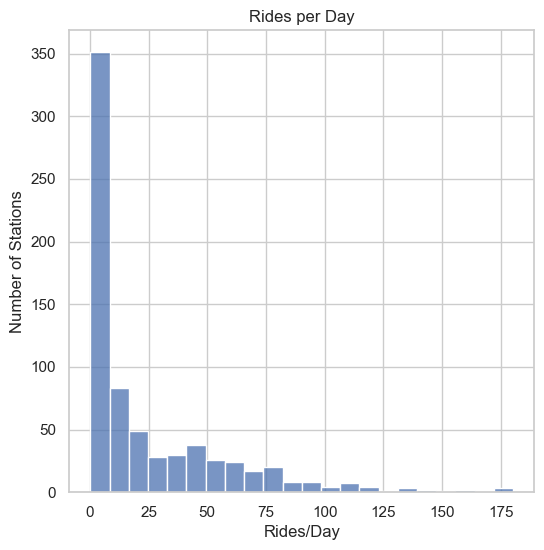

In [39]:
# TODO: plot rides/day

# set the style of seaborn
sns.set(style="whitegrid")

# create a figure with two side-by-side boxplots
plt.subplots(1, 1, figsize=(6, 6))

sns.histplot(data=established_stations, x='rides/day')

# set the title
plt.title(f'Rides per Day')

# set labels
plt.xlabel('Rides/Day')
plt.ylabel('Number of Stations')

# show the plot
plt.show()

In [40]:
established_stations['low_use'] = established_stations['rides/day'] <= 1
established_stations

,station_name,station_id,start_station_count,end_station_count,min_started_at,max_started_at,operation_time,end_lat,end_lng,rides/day,low_use
0,Maine Ave & 9th St SW,31646.0,40694,43141,2021-01-01 00:08:33,2023-06-30 23:39:26,910 days 23:30:53,38.880714,-77.025327,92.13,False
1,10th & U St NW,31111.0,19801,19750,2021-01-01 00:13:43,2023-06-30 23:17:45,910 days 23:04:02,38.917200,-77.025900,43.46,False
2,17th & Corcoran St NW,31214.0,51715,51910,2021-01-01 00:14:32,2023-06-30 23:39:19,910 days 23:24:47,38.912100,-77.038700,113.87,False
3,Wilson Blvd. & N. Vermont St.,31926.0,3607,3430,2021-01-01 00:15:45,2023-06-30 16:42:18,910 days 16:26:33,38.879477,-77.114563,7.73,False
4,11th & Park Rd NW,31651.0,24372,18892,2021-01-01 00:17:46,2023-06-30 23:24:22,910 days 23:06:36,38.931322,-77.028247,47.54,False
...,...,...,...,...,...,...,...,...,...,...,...
706,Marymount University / Yorktown Blvd & 26th St N,31977.0,194,166,2022-10-21 15:55:20,2023-06-28 10:12:43,249 days 18:17:23,38.904252,-77.127776,1.45,False
707,Reston Town Center Metro South,32258.0,137,129,2022-10-28 13:27:04,2023-06-29 19:21:31,244 days 05:54:27,38.952300,-77.361466,1.09,False
708,Fort Lincoln Dr & 33rd Pl NE,31537.0,268,246,2022-12-13 19:37:49,2023-06-30 14:05:37,198 days 18:27:48,38.921641,-76.955687,2.60,False
709,South Dakota Ave & Bladensburg Rd NE,31538.0,209,219,2022-12-17 10:30:17,2023-06-30 22:56:33,195 days 12:26:16,38.925200,-76.964896,2.19,False


In [41]:
established_stations['low_use'].value_counts()

low_use
False    640
True      70
Name: count, dtype: int64

In [42]:
established_stations[established_stations['low_use']].describe()

,station_id,start_station_count,end_station_count,min_started_at,max_started_at,operation_time,end_lat,end_lng,rides/day
count,70.000000,70.000000,70.000000,70,70,70,70.000000,70.000000,70.000000
mean,32100.785714,265.214286,248.157143,2021-03-11 10:46:08.300000,2023-06-25 05:13:41.242856960,835 days 18:27:32.942857136,38.973599,-77.153358,0.615571
min,31671.000000,97.000000,74.000000,2021-01-01 10:00:15,2022-12-18 15:25:25,506 days 21:02:01,38.798749,-77.366786,0.210000
25%,32025.500000,186.750000,178.250000,2021-01-03 21:09:15.249999872,2023-06-27 07:51:52,820 days 14:24:30.750000,38.917047,-77.238447,0.500000
50%,32086.000000,253.500000,239.500000,2021-01-13 06:09:55,2023-06-28 19:41:22,894 days 03:09:22.500000,38.964009,-77.164915,0.595000
75%,32227.750000,331.750000,314.750000,2021-03-12 13:33:24.750000128,2023-06-30 11:48:41,904 days 09:19:38,39.046044,-77.005658,0.755000
max,32901.000000,497.000000,415.000000,2022-02-07 21:56:40,2023-06-30 23:03:01,909 days 20:58:12,39.125828,-76.843263,1.000000
std,195.074188,98.869390,87.295207,NaN,NaN,105 days 14:45:11.287064196,0.096565,0.144861,0.192908


In [43]:
established_stations[established_stations['low_use']].sort_values(by='end_station_count', ascending=False)

,station_name,station_id,start_station_count,end_station_count,min_started_at,max_started_at,operation_time,end_lat,end_lng,rides/day,low_use
592,6035 Warehouse,32901.0,108,415,2021-01-14 14:44:04,2023-06-09 18:04:29,876 days 03:20:25,38.963810,-77.010266,0.60,True
598,Westpark & Park Run Dr,32207.0,402,410,2021-01-17 12:05:38,2023-06-30 13:22:08,894 days 01:16:30,38.928916,-77.225278,0.91,True
458,Piccard & W Gude Dr,32033.0,370,409,2021-01-02 14:20:06,2023-06-30 17:58:39,909 days 03:38:33,39.102212,-77.177091,0.86,True
601,Spring Hill Metro,32200.0,416,392,2021-01-17 14:02:21,2023-06-30 19:33:02,894 days 05:30:41,38.929261,-77.240654,0.90,True
537,Key West Ave & Siesta Key Way,32052.0,407,383,2021-01-04 15:29:36,2023-06-28 19:48:02,905 days 04:18:26,39.105295,-77.194774,0.87,True
...,...,...,...,...,...,...,...,...,...,...,...
584,Shady Grove Hospital,32042.0,119,123,2021-01-12 12:51:03,2022-12-18 15:25:25,705 days 02:34:22,39.097636,-77.196636,0.34,True
607,Ridge Rd Community Center,31718.0,131,114,2021-01-25 23:20:48,2023-06-13 12:32:01,868 days 13:11:13,38.876227,-76.940981,0.28,True
486,Medical Center Dr & Key West Ave,32041.0,101,87,2021-01-02 15:38:05,2023-06-18 09:42:30,896 days 18:04:25,39.103091,-77.196442,0.21,True
639,Inlet Ct & Wiehle Dr,32242.0,121,82,2021-07-18 09:03:49,2023-06-26 06:10:24,707 days 21:06:35,38.966006,-77.334170,0.29,True


In [70]:
# create a Folium Map centered around the mean coordinates
map_center = [established_stations['end_lat'].mean(), established_stations['end_lng'].mean()]
m = folium.Map(location=map_center, zoom_start=10)


# create FeatureGroups
low_use_group = folium.FeatureGroup(name='Low Use Stations')
high_use_group = folium.FeatureGroup(name='High Use Stations')

# add markers to the FeatureGroups
for index, row in established_stations[established_stations['low_use']].iterrows():
    html = row[['station_name', 'rides/day']].to_frame().to_html()
    folium.Marker([row['end_lat'], row['end_lng']],
                  popup=html,
                  icon=folium.Icon(color='darkred', icon='fa-bicycle', prefix='fa')).add_to(low_use_group)

for index, row in established_stations[~established_stations['low_use']].iterrows():
    html = row[['station_name', 'rides/day']].to_frame().to_html()
    folium.Marker([row['end_lat'], row['end_lng']],
                  popup=html,
                  icon=folium.Icon(color='green', icon='fa-bicycle', prefix='fa')).add_to(high_use_group)

# add FeatureGroups to the map
low_use_group.add_to(m)
high_use_group.add_to(m)

# add layer control to toggle between FeatureGroups
folium.LayerControl().add_to(m)

# save the map
m.save("maps/unused_stations.html")

# display the map
m

In [69]:
# create a Folium Map centered around the mean coordinates
map_center = [established_stations['end_lat'].mean(), established_stations['end_lng'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# filter data for low-use stations
low_use_data = established_stations[established_stations['low_use']]

# create HeatMap for low-use stations
hexbin_data = list(zip(low_use_data['end_lat'], low_use_data['end_lng']))
plugins.HeatMap(hexbin_data, radius=20, blur=10).add_to(m)

# save the map
m.save("maps/heat_map.html")

# display the map
m

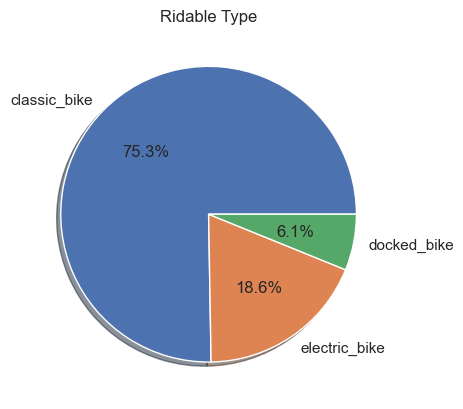

In [46]:
# check bike type and visualize

# create a figure and axis
fig1, ax1 = plt.subplots()

# data for the pie chart (based on the amount of entries per wine data set)
data = bike_data['rideable_type'].value_counts()

# labels for each section of the pie chart
labels=bike_data['rideable_type'].value_counts().index

# plot the pie chart (also show % using autopct, add a shadow and explode for aesthetics)
ax1.pie(data, labels=labels, autopct='%1.1f%%', shadow=True)

# set the title
plt.title(f'Ridable Type')

# show the plot
plt.show()

In [47]:
# take into account only stations operating for at least 180 days
half_year = pd.Timedelta(days=180)
short_stations = stations[(stations['operation_time'] < half_year)].copy()

In [48]:
short_stations.sort_values(by='operation_time')

,station_name,station_id,start_station_count,end_station_count,min_started_at,max_started_at,operation_time,end_lat,end_lng
744,Westbranch Dr & Jones Branch Dr,32270.0,1,1,2023-06-30 14:58:40,2023-06-30 14:58:40,0 days 00:00:00,38.931089,-77.220729
743,Arlington Blvd & Allen St,32268.0,2,2,2023-06-28 12:54:01,2023-06-29 17:09:48,1 days 04:15:47,38.866315,-77.199799
742,Jones Branch Dr & Blyton St,32269.0,5,4,2023-06-28 00:34:16,2023-06-30 18:37:17,2 days 18:03:01,38.926973,-77.217376
741,Route 29 & Bisvey Dr,32267.0,8,10,2023-06-22 22:50:23,2023-06-27 11:22:41,4 days 12:32:18,38.876912,-77.195847
740,Emma Lee St & Morris St,32266.0,9,9,2023-06-22 12:02:17,2023-06-30 08:17:40,7 days 20:15:23,38.877818,-77.209421
739,Pimmit Dr & Los Pueblos Ln,32265.0,16,20,2023-06-22 11:45:24,2023-06-30 20:23:09,8 days 08:37:45,38.900371,-77.205428
738,Pimmit Dr & Idyl Ln,32264.0,24,23,2023-06-21 20:55:47,2023-06-30 22:32:46,9 days 01:36:59,38.897692,-77.207261
737,24th St & Rhode Island Ave NE,31543.0,35,41,2023-06-07 20:03:45,2023-06-30 11:12:07,22 days 15:08:22,38.930774,-76.972851
736,Gatehouse Rd & Telestar Ct,32263.0,19,24,2023-05-21 10:04:38,2023-06-30 18:36:01,40 days 08:31:23,38.868536,-77.225262
735,Whitehaven Pkwy & Foxhall Rd NW / GWU Mt. Vernon,31390.0,144,106,2023-04-29 19:50:16,2023-06-30 10:43:12,61 days 14:52:56,38.916501,-77.090911


# ML

In [49]:
established_stations

,station_name,station_id,start_station_count,end_station_count,min_started_at,max_started_at,operation_time,end_lat,end_lng,rides/day,low_use
0,Maine Ave & 9th St SW,31646.0,40694,43141,2021-01-01 00:08:33,2023-06-30 23:39:26,910 days 23:30:53,38.880714,-77.025327,92.13,False
1,10th & U St NW,31111.0,19801,19750,2021-01-01 00:13:43,2023-06-30 23:17:45,910 days 23:04:02,38.917200,-77.025900,43.46,False
2,17th & Corcoran St NW,31214.0,51715,51910,2021-01-01 00:14:32,2023-06-30 23:39:19,910 days 23:24:47,38.912100,-77.038700,113.87,False
3,Wilson Blvd. & N. Vermont St.,31926.0,3607,3430,2021-01-01 00:15:45,2023-06-30 16:42:18,910 days 16:26:33,38.879477,-77.114563,7.73,False
4,11th & Park Rd NW,31651.0,24372,18892,2021-01-01 00:17:46,2023-06-30 23:24:22,910 days 23:06:36,38.931322,-77.028247,47.54,False
...,...,...,...,...,...,...,...,...,...,...,...
706,Marymount University / Yorktown Blvd & 26th St N,31977.0,194,166,2022-10-21 15:55:20,2023-06-28 10:12:43,249 days 18:17:23,38.904252,-77.127776,1.45,False
707,Reston Town Center Metro South,32258.0,137,129,2022-10-28 13:27:04,2023-06-29 19:21:31,244 days 05:54:27,38.952300,-77.361466,1.09,False
708,Fort Lincoln Dr & 33rd Pl NE,31537.0,268,246,2022-12-13 19:37:49,2023-06-30 14:05:37,198 days 18:27:48,38.921641,-76.955687,2.60,False
709,South Dakota Ave & Bladensburg Rd NE,31538.0,209,219,2022-12-17 10:30:17,2023-06-30 22:56:33,195 days 12:26:16,38.925200,-76.964896,2.19,False


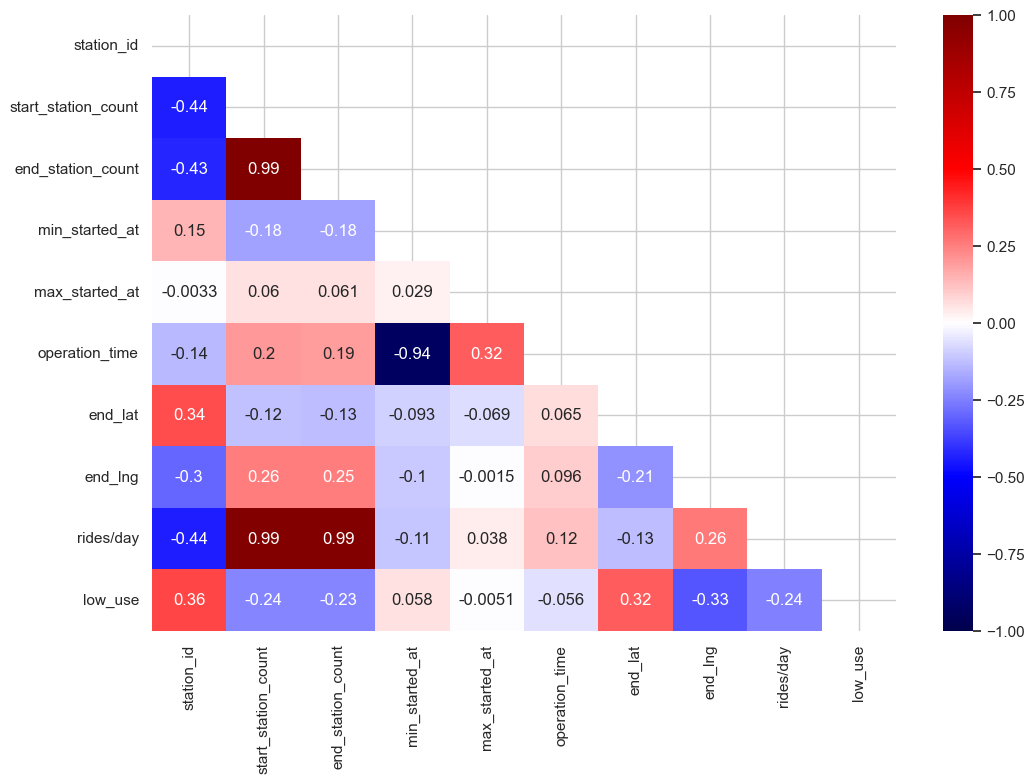

In [50]:
# plot correlation matrix for the df
plt.figure(figsize=(12,8))
corr= established_stations.drop(columns=['station_name']).corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, vmin=-1, vmax=1, cmap='seismic')
plt.show()

In [51]:
def evaluate_regression_model(y_test, y_pred):

    # calculate evaluation metrics
    mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
    #squared True returns MSE value, False returns RMSE value.
    mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
    rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    
    # return the metrics as a dictionary
    evaluation_dict = {
        'MAE': round(mae, 2),
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'R^2': round(r2, 2)
    }

    return evaluation_dict

In [52]:
# split the data into features (X) and target variable (y)
X = established_stations[['end_lat', 'end_lng']] # features
y = established_stations['rides/day']  # target variable

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# initialize the Linear Regression model
lr = LinearRegression()

# train the model
lr.fit(X_train, y_train)

# make predictions on the test set
y_pred = lr.predict(X_test)

result_dict = evaluate_regression_model(y_test, y_pred)
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Value'])
result_df

,Value
MAE,25.07
MSE,1223.38
RMSE,34.98
R^2,0.02


In [54]:
# transform features to include polynomial terms up to degree 3
poly_features = PolynomialFeatures(degree=3)
X_poly = poly_features.fit_transform(X_train)

# train a linear regression model using the polynomial features
poly_regression = LinearRegression()
poly_regression.fit(X_poly, y_train)

# make predictions on the test set
X_test_poly = poly_features.transform(X_test)
y_pred = poly_regression.predict(X_test_poly)

result_dict = evaluate_regression_model(y_test, y_pred)
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Value'])
result_df

,Value
MAE,20.87
MSE,940.22
RMSE,30.66
R^2,0.25


In [55]:
# initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)

# train the model
rf.fit(X_train, y_train)

# make predictions on the test set
y_pred = rf.predict(X_test)

result_dict = evaluate_regression_model(y_test, y_pred)
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Value'])
result_df

,Value
MAE,10.23
MSE,314.54
RMSE,17.74
R^2,0.75


In [56]:
# give it a lat lng grid

In [57]:
print(X_test.head())

       end_lat    end_lng
294  38.880705 -77.085960
256  38.983525 -77.095367
703  38.880761 -77.005741
357  38.876393 -77.107735
248  38.887378 -77.001955


In [58]:
# Step 1: Find the minimum and maximum values
min_lat = established_stations['end_lat'].min()
max_lat = established_stations['end_lat'].max()
min_lng = established_stations['end_lng'].min()
max_lng = established_stations['end_lng'].max()

# Step 2: Define the number of grid points or grid resolution
num_points_lat = 20  # Adjust as needed
num_points_lng = 20  # Adjust as needed

# Step 3: Generate a grid of latitude and longitude values
grid_lat = np.linspace(min_lat, max_lat, num_points_lat)
grid_lng = np.linspace(min_lng, max_lng, num_points_lng)

# Create a DataFrame with all combinations of latitude and longitude
grid_df = pd.DataFrame([(lat, lng) for lat in grid_lat for lng in grid_lng], columns=['end_lat', 'end_lng'])

# Display the grid DataFrame
print(grid_df)

       end_lat    end_lng
0    38.782633 -77.368375
1    38.782633 -77.339804
2    38.782633 -77.311234
3    38.782633 -77.282663
4    38.782633 -77.254093
..         ...        ...
395  39.125828 -76.939817
396  39.125828 -76.911247
397  39.125828 -76.882676
398  39.125828 -76.854106
399  39.125828 -76.825535

[400 rows x 2 columns]


In [59]:
# make predictions on the grid
y_pred = rf.predict(grid_df)
grid_df['rides/day'] = y_pred
grid_df

,end_lat,end_lng,rides/day
0,38.782633,-77.368375,1.8148
1,38.782633,-77.339804,1.8204
2,38.782633,-77.311234,1.8088
3,38.782633,-77.282663,1.8162
4,38.782633,-77.254093,1.8162
...,...,...,...
395,39.125828,-76.939817,1.4932
396,39.125828,-76.911247,1.4211
397,39.125828,-76.882676,1.3328
398,39.125828,-76.854106,1.2452


In [77]:
grid_df.describe()

,end_lat,end_lng,rides/day
count,400.000000,400.000000,400.000000
mean,38.954230,-77.096955,3.968835
std,0.104286,0.164952,9.936325
min,38.782633,-77.368375,0.393800
25%,38.868432,-77.232665,1.203075
50%,38.954230,-77.096955,1.721050
75%,39.040029,-76.961245,2.659300
max,39.125828,-76.825535,103.684200


In [111]:
# create a Folium Map centered around the mean coordinates
map_center = [grid_df['end_lat'].mean(), grid_df['end_lng'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Add CircleMarkers for each point with radius and color representing the values
for index, row in grid_df.iterrows():
    radius = row['rides/day']  # Adjust the scaling factor as needed
    color = 'blue'  # Adjust the color as needed
    folium.CircleMarker([row['end_lat'], row['end_lng']], radius=radius, color=color, fill=True, fill_color=color, fill_opacity=0.6).add_to(m)

# Save the map to an HTML file or display it
#m.save("map_with_circles.html")
m


In [87]:
df = grid_df.copy()
df.rename(columns={'end_lat': 'lat', 
                   'end_lng': 'lng',
                   'rides/day' : 'value'},
                   inplace=True)
df

,lat,lng,value
0,38.782633,-77.368375,1.8148
1,38.782633,-77.339804,1.8204
2,38.782633,-77.311234,1.8088
3,38.782633,-77.282663,1.8162
4,38.782633,-77.254093,1.8162
...,...,...,...
395,39.125828,-76.939817,1.4932
396,39.125828,-76.911247,1.4211
397,39.125828,-76.882676,1.3328
398,39.125828,-76.854106,1.2452


In [114]:
# Create a Folium map centered around the mean coordinates
map_center = [df['lat'].mean(), df['lng'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Define the minimum and maximum values
min_value = df['value'].min()
max_value = df['value'].max()

# Create a custom function to map values to colors (blue to red)
def value_to_color(value):
    normalized_value = (value - min_value) / (max_value - min_value)
    rgb_color = plt.cm.RdBu_r(normalized_value)[:3]  # Using RdBu_r for blue to red
    hex_color = rgb2hex(rgb_color)
    return hex_color

# Add CircleMarkers to the map with tooltips displaying the actual values
for index, row in df.iterrows():
    color = value_to_color(row['value'])
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        tooltip=f"Value: {row['value']:.2f}"
    ).add_to(m)

# Save the map to an HTML file or display it
#m.save("map_without_legend.html")
m